In [53]:
import sys
sys.path.append("..")

import pandas as pd
from tabulate import tabulate
import talib
import matplotlib.pyplot as plt
from pynance import portfolio_optimizer as po

In [54]:
print("Loading stock data from CSV files")
TICKERS = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]

stock_data = {}

for t in TICKERS:
    df = pd.read_csv(f"../data/finance_data/{t}.csv")
    stock_data[t] = df

Loading stock data from CSV files


In [55]:
print("Checking for missing values in each dataset:")
for ticker, df in stock_data.items():
    print(f"\nSummary statistics for {ticker}:")
    missing_summary = df.isna().sum().reset_index()
    missing_summary.columns = ['Column', 'Missing Values']
    print(tabulate(missing_summary, headers="keys", tablefmt="psql", showindex=False))

Checking for missing values in each dataset:

Summary statistics for AAPL:
+----------+------------------+
| Column   |   Missing Values |
|----------+------------------|
| Date     |                0 |
| Close    |                0 |
| High     |                0 |
| Low      |                0 |
| Open     |                0 |
| Volume   |                0 |
+----------+------------------+

Summary statistics for AMZN:
+----------+------------------+
| Column   |   Missing Values |
|----------+------------------|
| Date     |                0 |
| Close    |                0 |
| High     |                0 |
| Low      |                0 |
| Open     |                0 |
| Volume   |                0 |
+----------+------------------+

Summary statistics for GOOG:
+----------+------------------+
| Column   |   Missing Values |
|----------+------------------|
| Date     |                0 |
| Close    |                0 |
| High     |                0 |
| Low      |                0 |
|

In [56]:
stat_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

for ticker, df in stock_data.items():
    print("Basic Statis tics for", ticker)
    print(tabulate(df[stat_columns].describe(), headers="keys", tablefmt="psql"))

Basic Statis tics for AAPL
+-------+------------+------------+-----------+-----------+----------------+
|       |       Open |       High |       Low |     Close |         Volume |
|-------+------------+------------+-----------+-----------+----------------|
| count | 3774       | 3774       | 3774      | 3774      | 3774           |
| mean  |   53.8016  |   54.3838  |   53.2475 |   53.8412 |    2.64064e+08 |
| std   |   55.0092  |   55.6272  |   54.4401 |   55.064  |    2.34563e+08 |
| min   |    2.38099 |    2.45927 |    2.3453 |    2.3453 |    2.40483e+07 |
| 25%   |   15.0076  |   15.183   |   14.9019 |   15.0504 |    9.58184e+07 |
| 50%   |   27.0102  |   27.1688  |   26.8368 |   26.9758 |    1.66735e+08 |
| 75%   |   74.1279  |   75.2524  |   73.5536 |   74.6642 |    3.77741e+08 |
| max   |  196.167   |  197.752   |  195.157  |  196.257  |    1.881e+09   |
+-------+------------+------------+-----------+-----------+----------------+
Basic Statis tics for AMZN
+-------+-----------+-

In [57]:
print("Cleaning and aligning datasets:")

summary = []

date_sets = [set(pd.to_datetime(df["Date"])) for df in stock_data.values()]
common_dates = set.intersection(*date_sets)

for ticker, df in stock_data.items():
    before_rows = df.shape[0]

    # Convert Date column to datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    # Drop duplicates
    df.drop_duplicates(subset="Date", inplace=True)

    # Filter to common dates
    df = df[df["Date"].isin(common_dates)].copy()

    # Sort by date
    df.sort_values("Date", inplace=True)

    # Adjust index
    df.reset_index(drop=True, inplace=True)

    # Get after rows
    after_rows = df.shape[0]

    # Save back to dictionary
    stock_data[ticker] = df

    summary.append(
        {
            "Ticker": ticker,
            "Rows Before": before_rows,
            "Rows After": after_rows,
            "Duplicates Removed": before_rows - after_rows,
            "Date dtype": df["Date"].dtype,
        }
    )

print(tabulate(summary, headers="keys", tablefmt="psql"))

Cleaning and aligning datasets:
+----------+---------------+--------------+----------------------+----------------+
| Ticker   |   Rows Before |   Rows After |   Duplicates Removed | Date dtype     |
|----------+---------------+--------------+----------------------+----------------|
| AAPL     |          3774 |         2923 |                  851 | datetime64[ns] |
| AMZN     |          3774 |         2923 |                  851 | datetime64[ns] |
| GOOG     |          3774 |         2923 |                  851 | datetime64[ns] |
| META     |          2923 |         2923 |                    0 | datetime64[ns] |
| MSFT     |          3774 |         2923 |                  851 | datetime64[ns] |
| NVDA     |          3774 |         2923 |                  851 | datetime64[ns] |
+----------+---------------+--------------+----------------------+----------------+


Visualizing Closing Prices Over Time


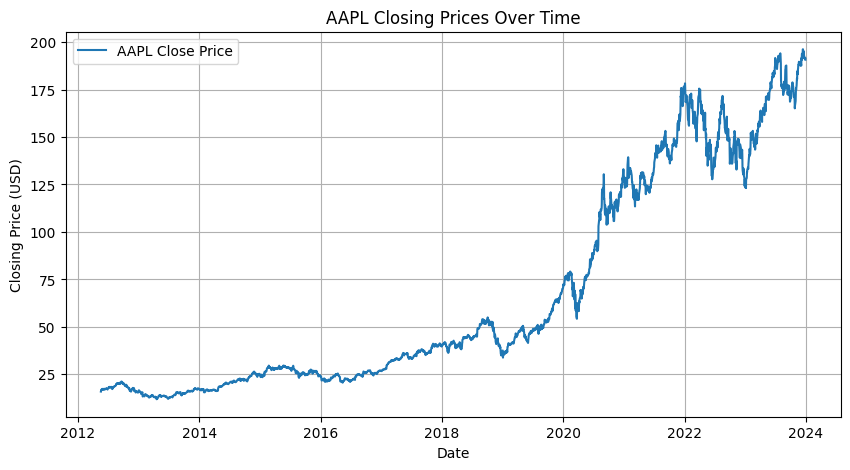

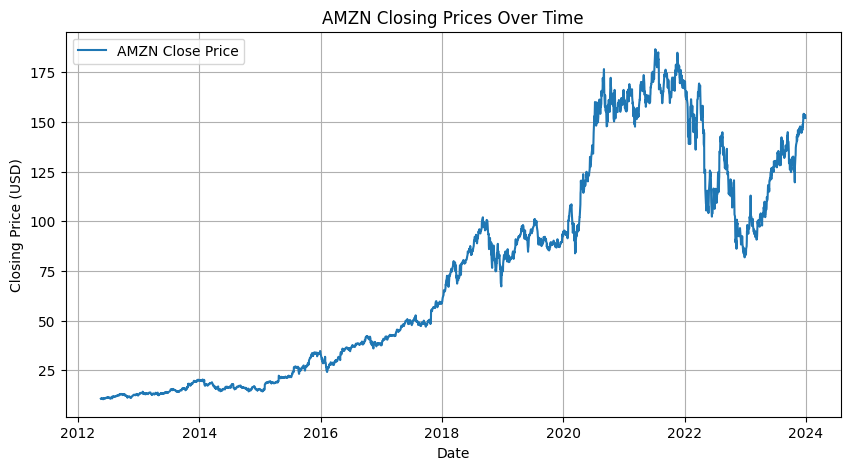

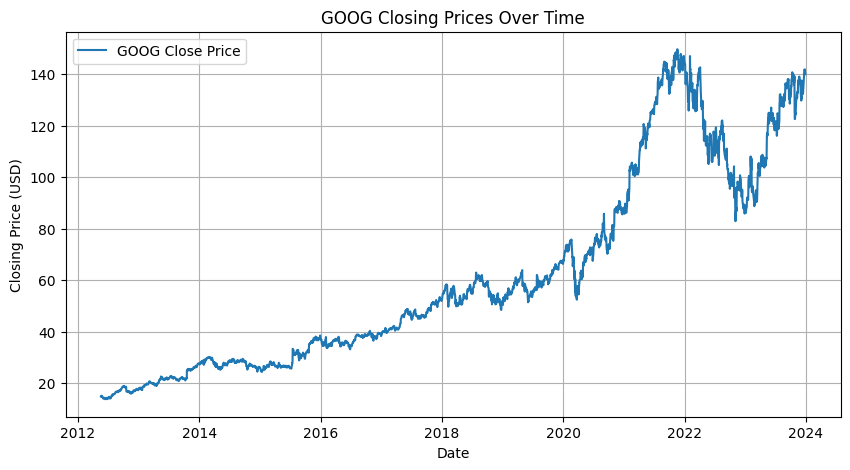

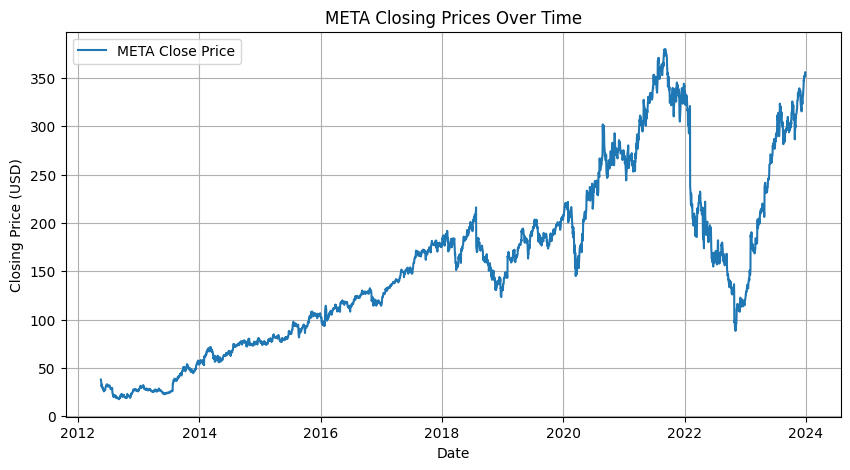

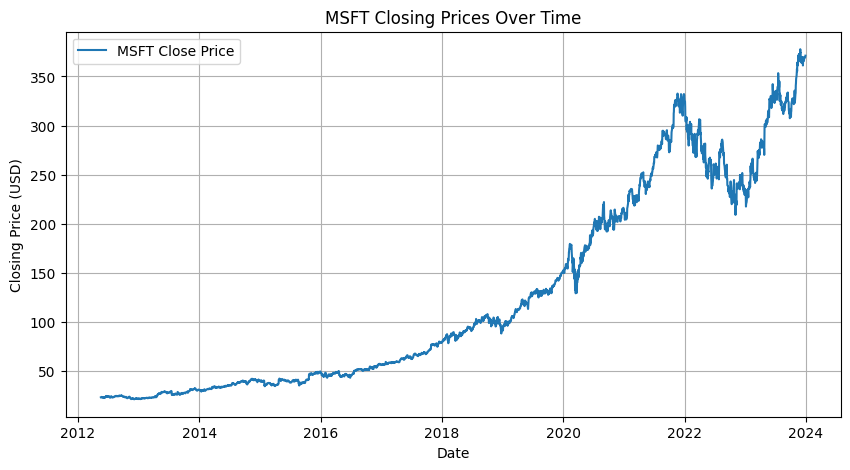

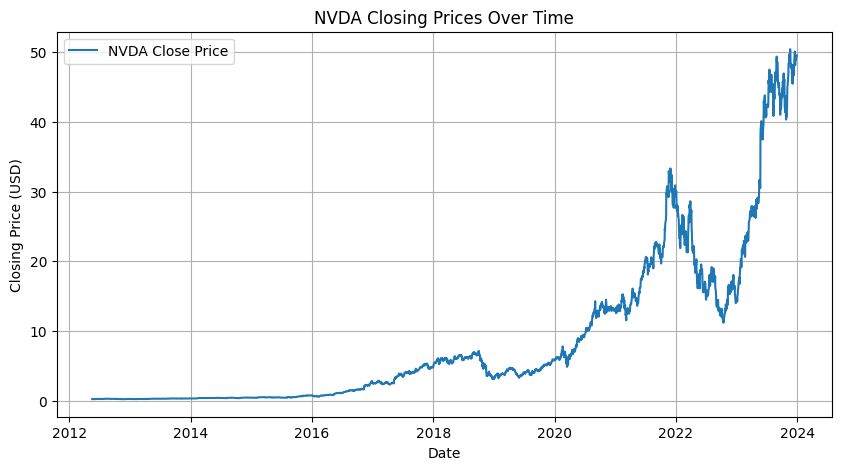

In [58]:
print("Visualizing Closing Prices Over Time")

for ticker, df in stock_data.items():
    plt.figure(figsize=(10,5))
    plt.plot(df['Date'], df['Close'], label=f"{ticker} Close Price")
    plt.title(f"{ticker} Closing Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()


In [59]:
print("Analysis with TA-Lib")

summary = []

for ticker, df in stock_data.items():

    closing_price=df["Close"]

    # Simple Moving Average (SMA) for 20 days
    df["SMA_20"] = talib.SMA(closing_price, timeperiod=20)

    # Exponential Moving Average (EMA) for 20 days
    df["EMA_20"] = talib.EMA(closing_price, timeperiod=20)

    # Relative Strength Index (RSI) for 14 days
    df["RSI_14"] = talib.RSI(closing_price, timeperiod=14)

    macd, macd_signal, macd_hist = talib.MACD(
        closing_price, fastperiod=12, slowperiod=26, signalperiod=9
    )
    df["MACD"] = macd
    df["MACD_Signal"] = macd_signal
    df["MACD_Hist"] = macd_hist

    last_row = df.iloc[-1]
    summary.append(
        {
            "Ticker": ticker,
            "Total Rows": df.shape[0],
            "Closing": round(last_row["Close"], 2),
            "SMA_20": round(last_row["SMA_20"], 2),
            "EMA_20": round(last_row["EMA_20"], 2),
            "RSI_14": round(last_row["RSI_14"], 2),
            "MACD": round(last_row["MACD"], 4),
            "MACD_Signal": round(last_row["MACD_Signal"], 4),
            "MACD_Hist": round(last_row["MACD_Hist"], 4),
        }
    )

print("\nSummary of TA-Lib Indicators:")
print(tabulate(summary, headers="keys", tablefmt="psql"))

Analysis with TA-Lib

Summary of TA-Lib Indicators:
+----------+--------------+-----------+----------+----------+----------+--------+---------------+-------------+
| Ticker   |   Total Rows |   Closing |   SMA_20 |   EMA_20 |   RSI_14 |   MACD |   MACD_Signal |   MACD_Hist |
|----------+--------------+-----------+----------+----------+----------+--------+---------------+-------------|
| AAPL     |         2923 |    190.73 |   192.49 |   191.43 |    51.12 | 1.5595 |        2.4246 |     -0.8651 |
| AMZN     |         2923 |    151.94 |   149.82 |   150.21 |    59.01 | 2.782  |        2.923  |     -0.141  |
| GOOG     |         2923 |    139.97 |   135.98 |   137.41 |    59.31 | 1.8428 |        1.3059 |      0.5369 |
| META     |         2923 |    351.79 |   336.87 |   341.66 |    64.3  | 8.1933 |        6.6935 |      1.4998 |
| MSFT     |         2923 |    371.21 |   367.79 |   367.79 |    57.95 | 2.6536 |        3.1496 |     -0.496  |
| NVDA     |         2923 |     49.5  |    48.05 |  

Visualizing Closing Prices with TA-Lib Indicators
AAPL


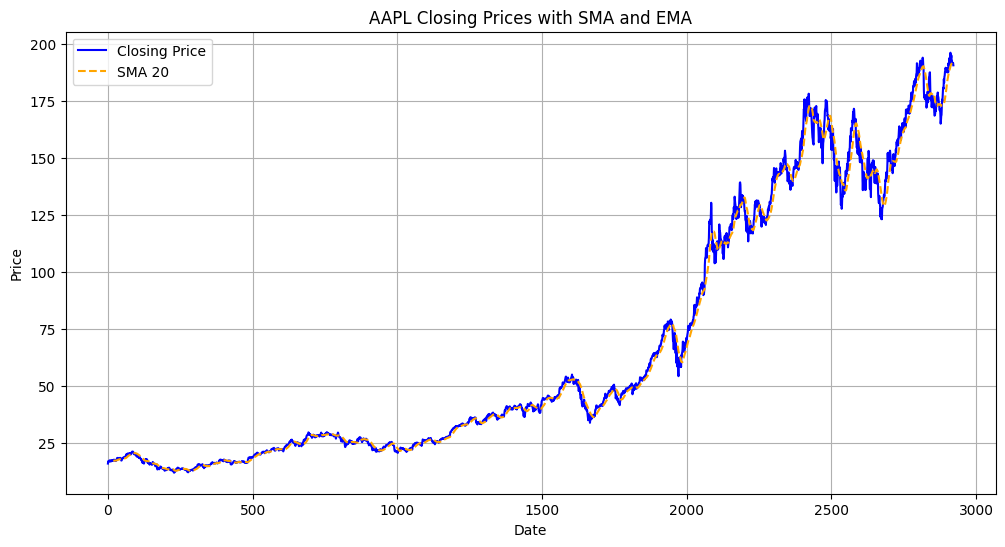

AMZN


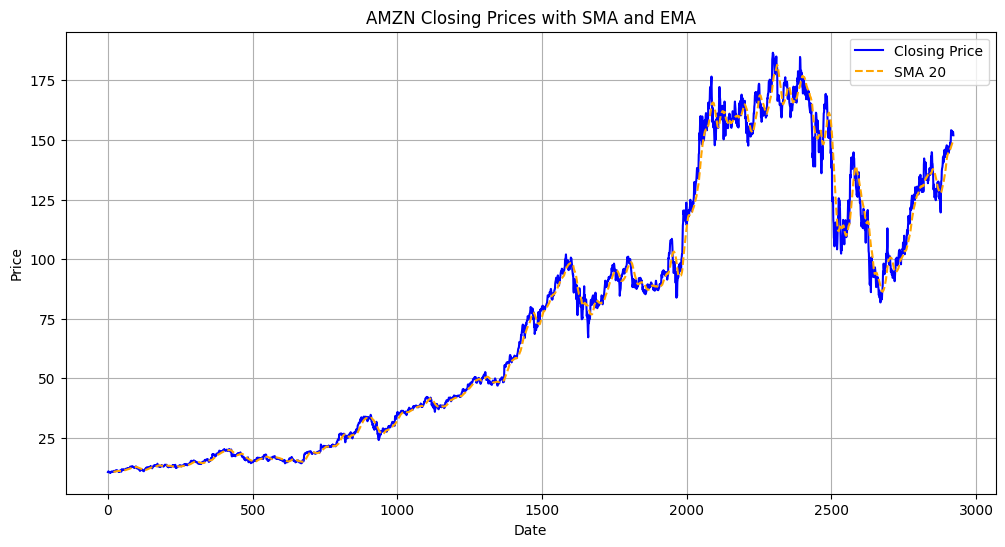

GOOG


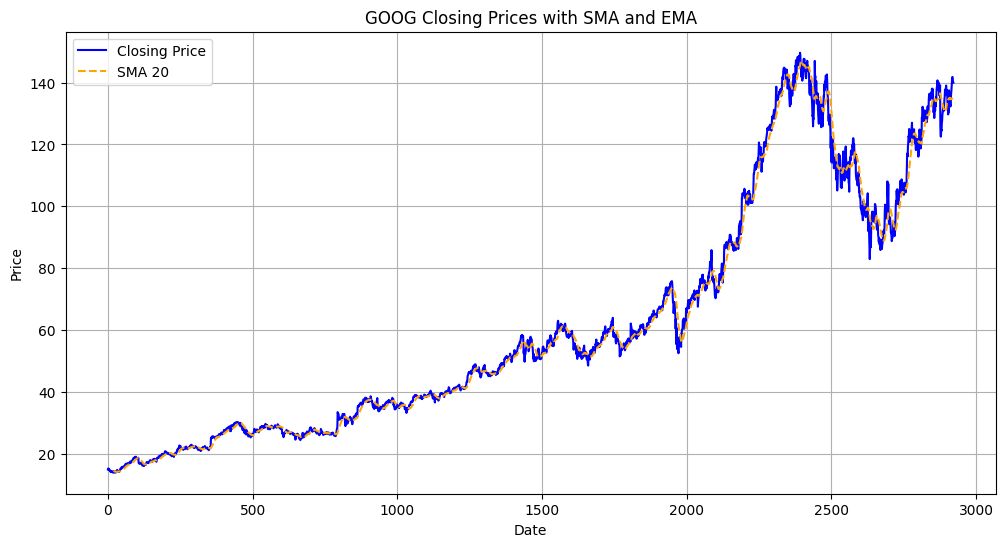

META


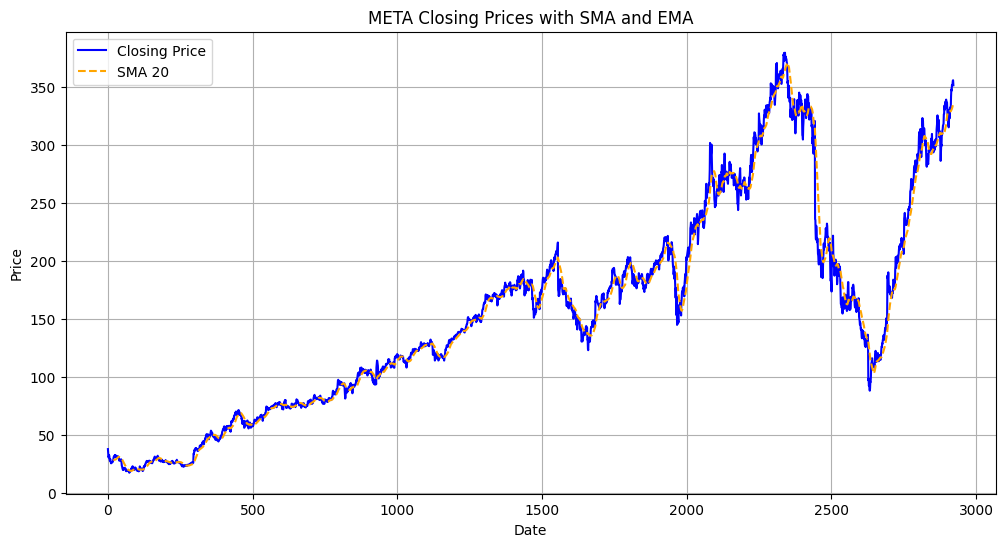

MSFT


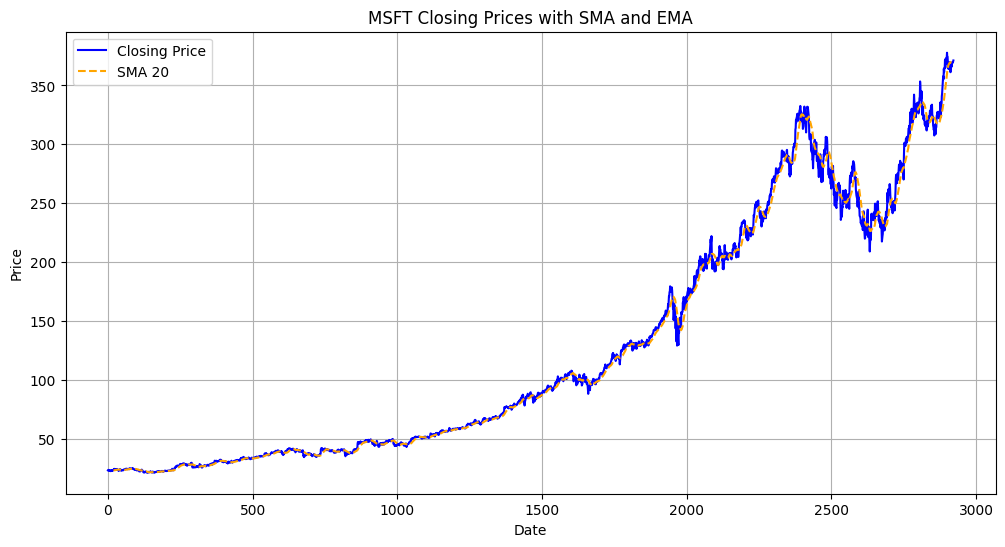

NVDA


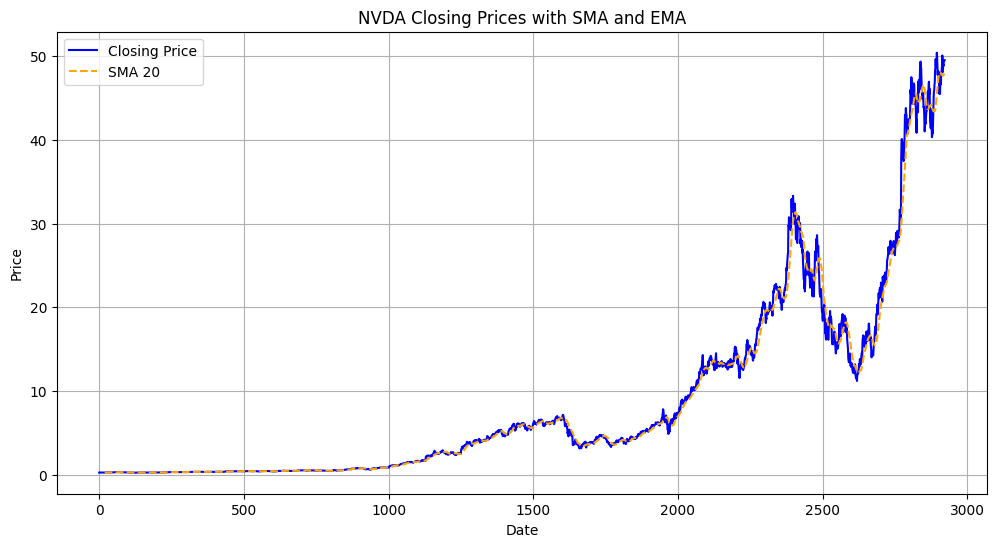

In [60]:
print("Visualizing Closing Prices with TA-Lib Indicators")

for ticker, df in stock_data.items():
    closing_price=df["Close"]
    print(f"{ticker}")
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, closing_price, label='Closing Price', color='blue')
    ax.plot(df.index, df['SMA_20'], label='SMA 20', color='orange', linestyle='--')
    ax.set_title(f"{ticker} Closing Prices with SMA and EMA")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid()
    plt.show()


Visualizing RSI Over Time
AAPL RSI


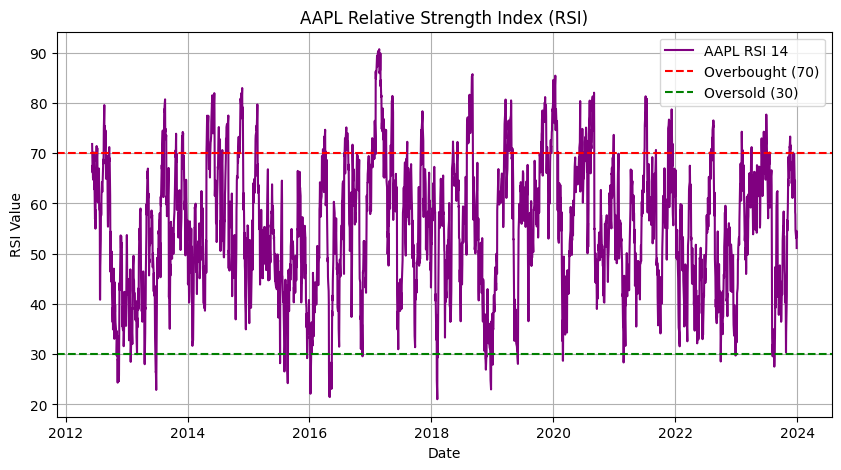

AMZN RSI


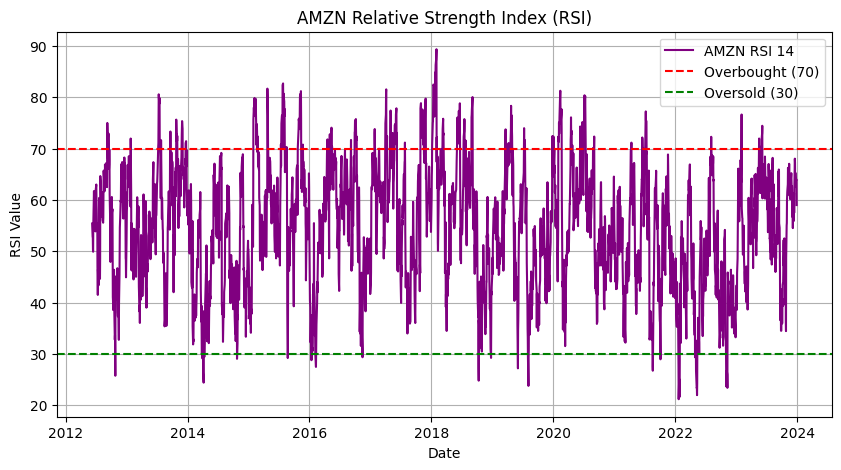

GOOG RSI


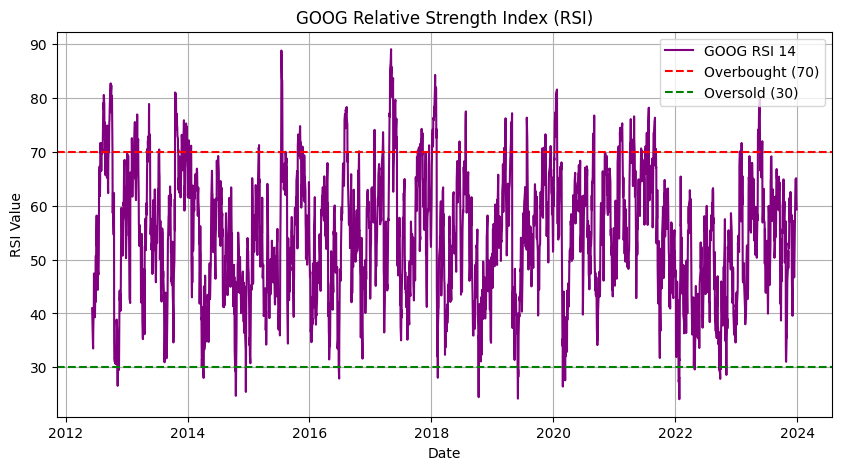

META RSI


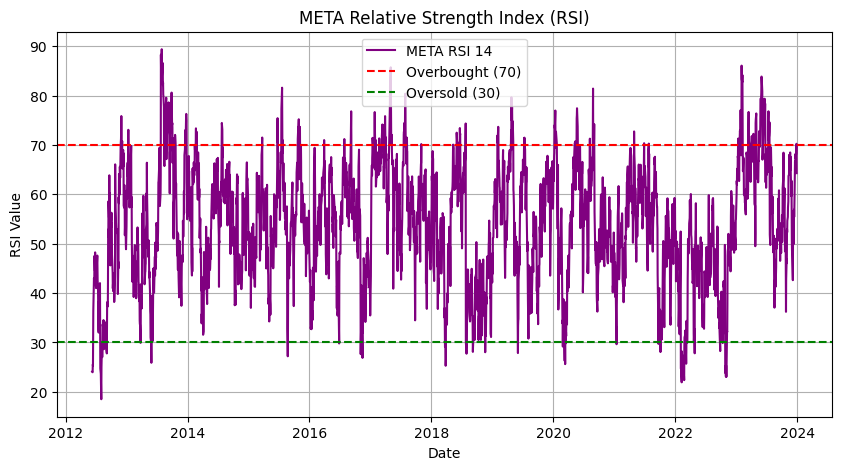

MSFT RSI


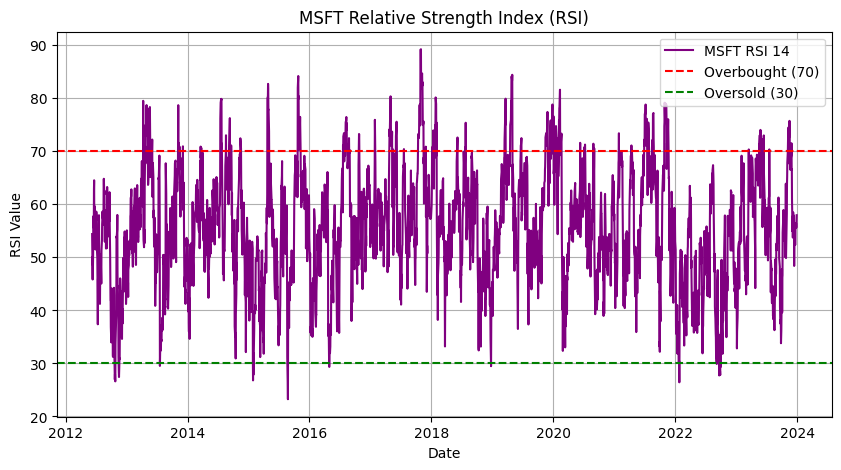

NVDA RSI


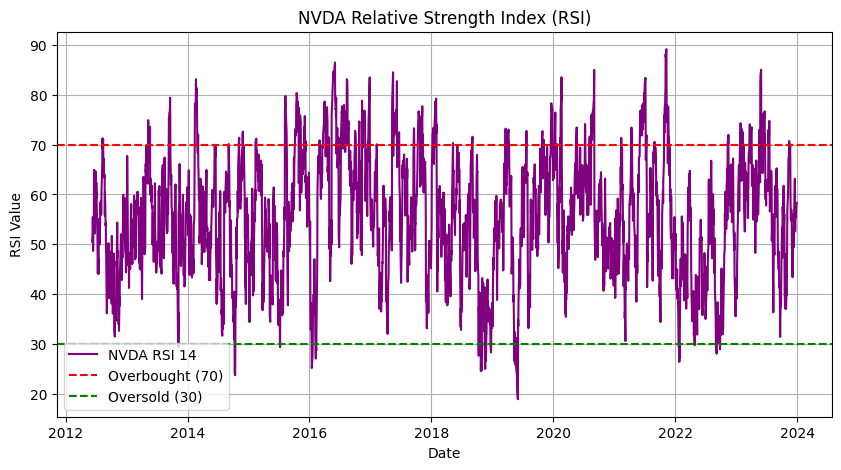

In [61]:
print("Visualizing RSI Over Time")

for ticker, df in stock_data.items():
    print(f"{ticker} RSI")
    plt.figure(figsize=(10,5))
    plt.plot(df['Date'], df['RSI_14'], label=f"{ticker} RSI 14", color='purple')
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f"{ticker} Relative Strength Index (RSI)")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid()
    plt.show()

Visualizing MACD momentum
AAPL MACD


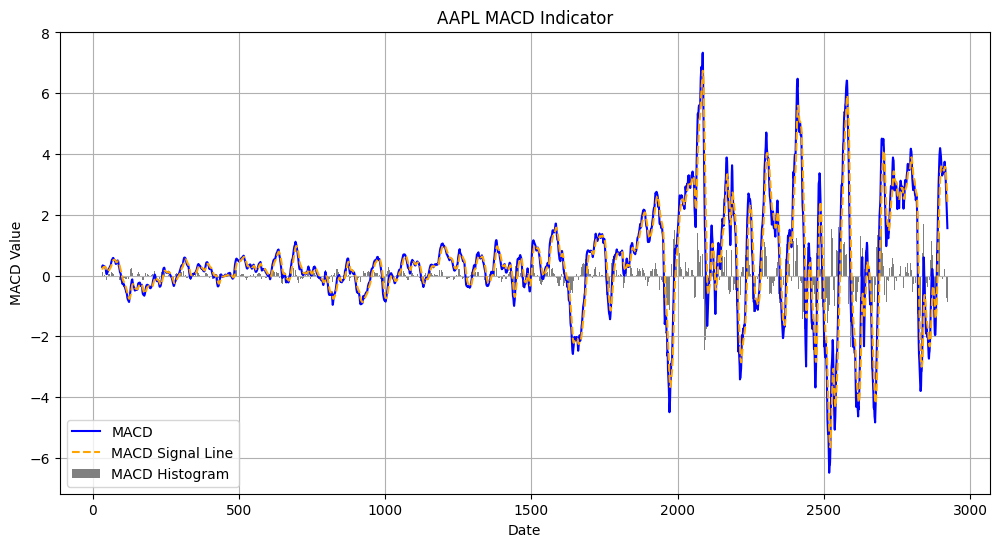

AMZN MACD


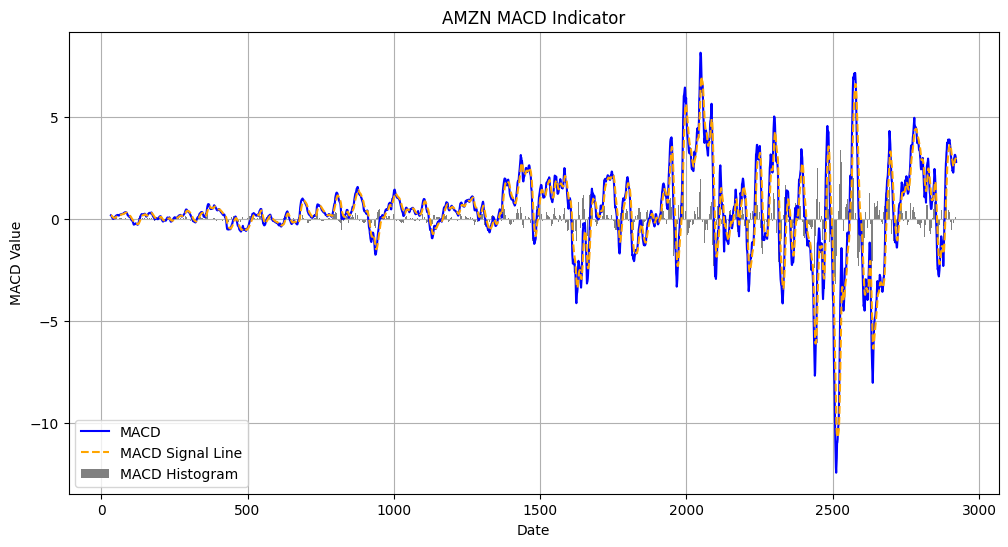

GOOG MACD


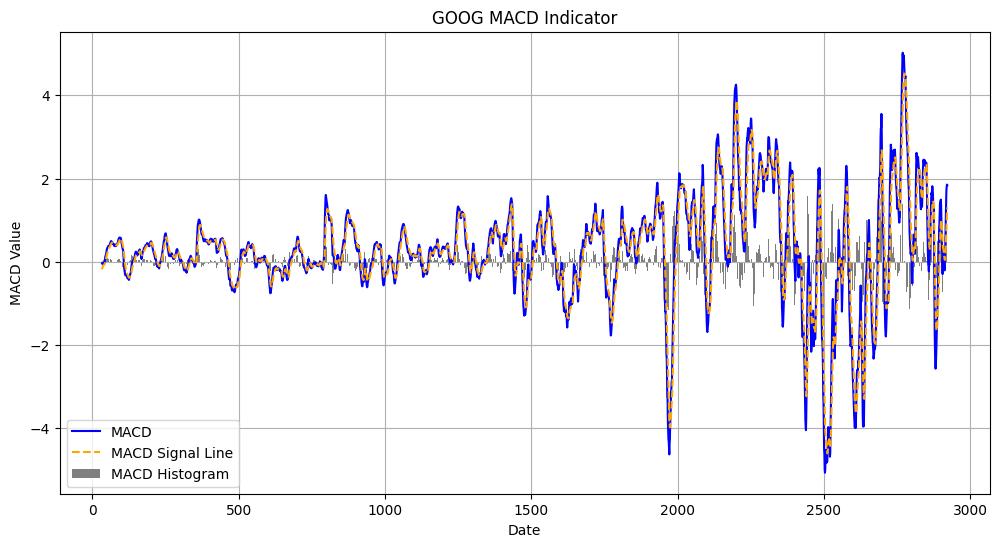

META MACD


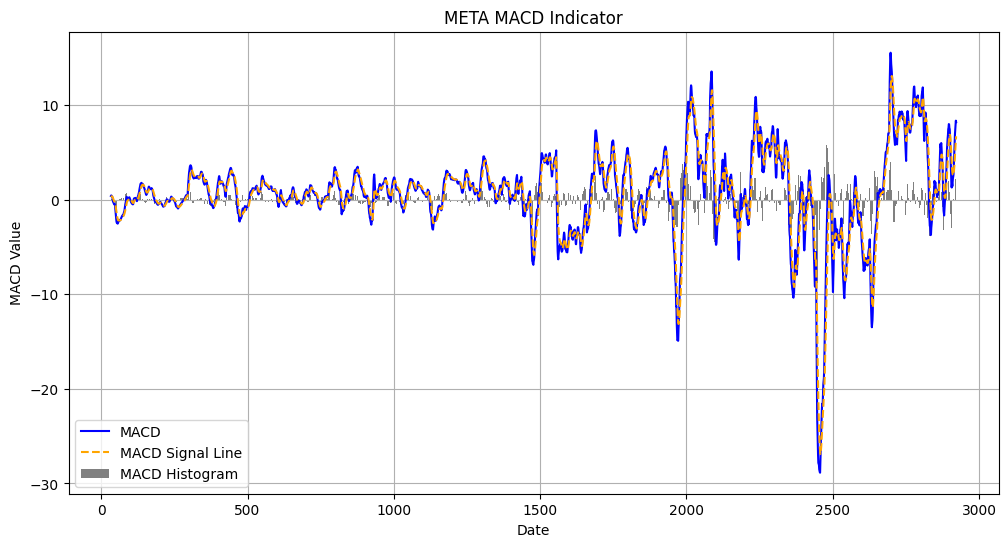

MSFT MACD


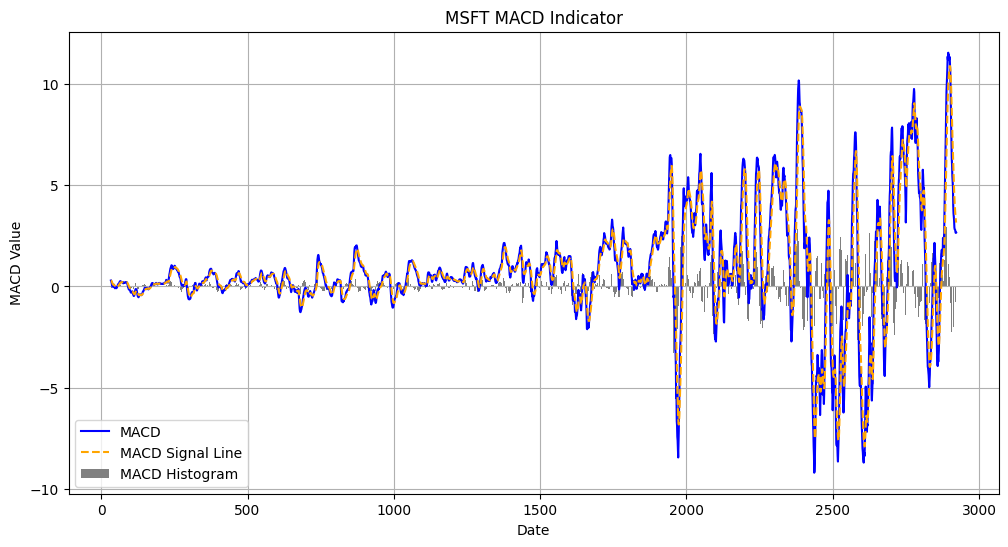

NVDA MACD


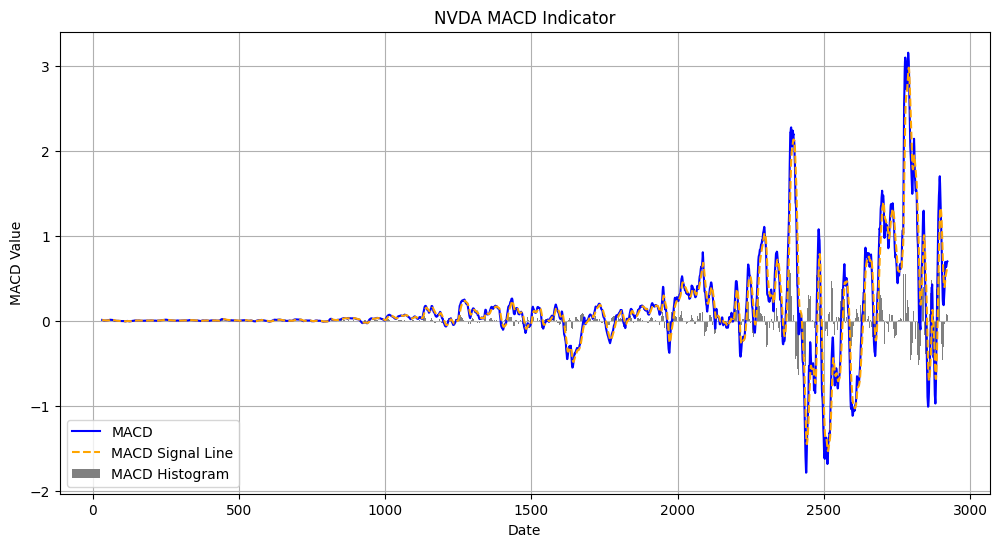

In [62]:
print("Visualizing MACD momentum")


for ticker, df in stock_data.items():
    print(f"{ticker} MACD")
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['MACD'], label='MACD', color='blue')
    ax.plot(
        df.index,
        df["MACD_Signal"],
        label="MACD Signal Line",
        color="orange",
        linestyle="--",
    )
    ax.bar(df.index, df['MACD_Hist'], label='MACD Histogram', color='gray')
    ax.set_title(f"{ticker} MACD Indicator")
    ax.set_xlabel("Date")
    ax.set_ylabel("MACD Value")
    ax.legend()
    ax.grid()
    plt.show()

In [68]:
print("PyNance Analysis")

# Initialize PortfolioCalculations with the list of tickers
portfolio = po.PortfolioCalculations(TICKERS)

# Max Sharpe Portfolio
sharpe_metrics = portfolio.max_sharpe_portfolio("rr")  # risk/return summary
sharpe_weights = portfolio.max_sharpe_portfolio("df")  # allocation DataFrame

# Min Variance Portfolio
minvol_metrics = portfolio.min_var_portfolio("rr")  # risk/return summary
minvol_weights = portfolio.min_var_portfolio("df")  # allocation DataFrame

print("Max Sharpe Portfolio")
print("\nRisk/Return Metrics")
print(sharpe_metrics)

print("\Portfolio Weights")
print(sharpe_weights.head())

print("\nMin Variance Portfolio")
print("\nRisk/Return Metrics")
print(minvol_metrics)

print("\Portfolio Weights")
print(minvol_metrics.head())


PyNance Analysis


/Users/elshaday/DEV/10Academy/sentiment-analysis-week1/venv/lib/python3.10/site-packages/pynance/datasources/data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_close_data[-1] == 0:
/Users/elshaday/DEV/10Academy/sentiment-analysis-week1/venv/lib/python3.10/site-packages/pynance/datasources/data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adj_close_data[-1] == 0:
/Users/elshaday/DEV/10Academy/sentiment-analysis-week1/venv/lib/python3.10/site-packages/pynance/datasources/data_retriever.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fu

Max Sharpe Portfolio

Risk/Return Metrics
                   Max Sharpe Portfolio
Expected Return                  61.96%
Standard Deviation               35.59%
\Portfolio Weights
     Portfolio Weight
AAPL            0.00%
AMZN            0.00%
GOOG           47.22%
META            0.00%
MSFT            0.00%

Min Variance Portfolio

Risk/Return Metrics
                   Min Var Portfolio
Expected Return               22.17%
Standard Deviation            20.03%
\Portfolio Weights
                   Min Var Portfolio
Expected Return               22.17%
Standard Deviation            20.03%
